In [1]:
library(igraph)
library(tidygraph)
library(magrittr)
library(ggrepel)
library(tidyverse)
library(cowplot)
suppressMessages(library(network))
suppressMessages(library(sna))
library(ggnetwork)
library(scatterpie)
library(blur)
library(ggupset)

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA) # get rid of legend panel bg
)

theme_set(theme_cowplot() + theme_transparent)

results <- '../../results/'

fam <- read_delim('~/data/genesis/genesis_2019.fam', delim = ' ', 
                  col_names = FALSE, col_types = 'iciiii')
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    left_join(vegas, by = c('name' = 'Gene'))
ppi_df <- as_tibble(ppi)

methods <- c('dmGWAS','heinz','HotNet2','LEAN','SConES GS',
             'SConES GM','SConES GI','SigMod','All')
method_palette <- c('dmGWAS' = '#4daf4a', 'heinz' = '#984ea3',
                    'HotNet2' = '#ff6f3c', 'SConES GI' = '#cb181d',
                    'SConES~GI' = '#cb181d',
                    'SigMod' = '#377eb8', 'All' = 'gray50', 
                    'Consensus' = 'black', 'chi^2~+~Bonferroni' = '#000080',
                    'VEGAS2' = 'gray50', 'LEAN' = '#8d6262')
labs <- c('all_snps' = 'All', 'chi2' = bquote(chi^2 ~ '+ Bonferroni'), 
          'consensus' = 'Consensus', 'dmgwas' = 'dmGWAS', 'heinz' = 'heinz', 
          'hotnet2' = 'HotNet2', 'lean' = 'LEAN', 'scones_gi' = 'SConES GI', 
          'scones_gm' = 'SConES GM', 'scones_gs' = 'SConES GS', 'sigmod' = 'SigMod')

Warning message:
“package ‘igraph’ was built under R version 4.0.3”

Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘tidygraph’


The following object is masked from ‘package:igraph’:

    groups


The following object is masked from ‘package:stats’:

    filter


Warning message:
“package ‘magrittr’ was built under R version 4.0.3”
Warning message:
“package ‘ggrepel’ was built under R version 4.0.3”
Loading required package: ggplot2

Warning message:
“package ‘ggplot2’ was built under R version 4.0.3”
── Attaching packages ─────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

Warning message:
“package ‘tibble’ was built under R version 4.0.3”
Warning message:
“package ‘readr’ was built under R ve

# Figure 1: Solutions overview

In [2]:
##########################
#     MANHATTAN PANEL    # 
##########################
gwas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                        col_types = 'iciddddddcd') %>%
    mutate(selected = ifelse(`Top-0.1-pvalue` < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='Chr') %>%

  # Add a cumulative position of each gene
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$`Top-0.1-pvalue`), na.rm = TRUE) + 1
axisdf <- don %>% 
    group_by(Chr) %>% 
    summarize(center=( max(BPcum) + min(BPcum) ) / 2 ) %>%
    mutate(chr_fix = ifelse(Chr %in% c(11,13,15,17,19,20,22), '', Chr))

options(repr.plot.width=12, repr.plot.height=7.5)
gene_manhattan <- ggplot(don, aes(x=BPcum, y=-log10(`Top-0.1-pvalue`))) +

    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha = .8, size = .75) +
    scale_color_manual(values = rep(c("#cbf1f5", "#a6e3e9"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = '#e84545') +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr_fix, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 10),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(gene P-value)')) +
    theme_transparent

dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
dmgwas_mh <- gene_manhattan + geom_point(data = filter(don, Gene %in% dmgwas), 
                                         aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), 
                                         color = '#2b2e4a', size = .75)

heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
heinz_mh <- gene_manhattan + geom_point(data = filter(don, Gene %in% heinz), 
                                        aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), 
                                        color = '#2b2e4a', size = .75)

hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')$gene
hotnet2_mh <- gene_manhattan + geom_point(data = filter(don, Gene %in% hotnet2), 
                                          aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), 
                                          color = '#2b2e4a', size = .75)

sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
sigmod_mh <- gene_manhattan + geom_point(data = filter(don, Gene %in% sigmod), 
                                         aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), 
                                         color = '#2b2e4a', size = .75)

map <- read_tsv('~/data/genesis/genesis_2019.bim',
                col_names = F, col_types = 'icidcc') %>%
       set_colnames(c('chr', 'snp', 'cm', 'pos', 'x1', 'x2')) %>%
       select(-cm, -x1, -x2)

snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc') %>%
    filter(!grepl('LINC', gene))

gwas <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdccccddd') %>%
    rename(chr = CHR, snp = SNP) %>%
    inner_join(map, by = c('chr', 'snp')) %>%
    mutate(selected = ifelse(P < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(chr) %>% 
  summarise(chr_len=max(pos)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='chr') %>%

  # Add a cumulative position of each SNP
  arrange(chr, pos) %>%
  mutate( BPcum=pos+tot) %>%
  left_join(arrange(snp2gene, gene) %>% group_by(snp) %>% summarize(gene = head(gene, 1)), by = 'snp')

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
axisdf <- don %>% 
    group_by(chr) %>% 
    summarize(center=( max(BPcum) + min(BPcum) ) / 2 ) %>%
    mutate(chr_fix = ifelse(chr %in% c(11,13,15,17,19,20,22), '', chr))

snp_manhattan <- ggplot(don, aes(x=BPcum, y=-log10(P))) +

    # Show all points
    geom_point( aes(color=as.factor(chr)), alpha=0.8, size= .75) +
    scale_color_manual(values = rep(c("#cbf1f5", "#a6e3e9"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = '#e84545') +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr_fix, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 10),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(SNP P-value)')) +
    theme_transparent

scones_gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp
scones_gi_mh <- snp_manhattan + geom_point(data = filter(don, snp %in% scones_gi), 
                                           aes(x=BPcum, y=-log10(P)), 
                                           color = '#2b2e4a', size = .75)

manhattan_panel <- plot_grid(dmgwas_mh, heinz_mh, 
                             hotnet2_mh, scones_gi_mh, sigmod_mh, 
                             #labels = c('Consensus','dmGWAS','heinz','HotNet2','SConES GI','SigMod'),
                             labels = c('dmGWAS','heinz','HotNet2','SConES GI','SigMod'),
                             nrow = 2)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [3]:
##########################
#     TOPOLOGY PANEL     # 
##########################
plot_network <- function(net, selected_nodes) {
    
    graph <- activate(net, nodes) %>%
        filter(name %in% selected_nodes)
    class(graph) <- c('igraph','tbl_graph')
    
    ggnetwork(graph) %>%
        ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
            geom_edges(color = '#323232') +
            geom_nodes(color = '#212121') +
            ggtitle(' ') +
            theme_blank() + theme_transparent + 
            theme(title = element_text(hjust = 1, face = 'bold'))
}

# dmgwas
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
dmgwas_plt <- plot_network(ppi, dmgwas)

# heinz
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
heinz_plt <- plot_network(ppi, heinz)

# hotnet2
hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')$gene
hotnet2_plt <- plot_network(ppi, hotnet2)

# lean
lean_plt <- ggplot() + geom_blank() + theme_blank() + theme_transparent

# scones
load(paste0(results,'scones/gi_network.betweenness.RData'))
scones_gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp
scones_gi_plt <- plot_network(gi_net, scones_gi)

# sigmod
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
sigmod_plt <- plot_network(ppi, sigmod)

# add consensus network
set.seed(0)
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'),  col_types = 'cdidllllllli')$gene
consensus_plt <- plot_network(ppi, consensus)

topology_panel <- plot_grid(dmgwas_plt, heinz_plt, hotnet2_plt, scones_gi_plt, sigmod_plt, 
                            #labels = c('Consensus','dmGWAS','heinz','HotNet2','SConES GI','SigMod'))
                            labels = c('dmGWAS','heinz','HotNet2','SConES GI','SigMod'))

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”


In [4]:
##########################
#  HETEROGENEITY PANEL   # 
##########################
methods <- c('dmGWAS','heinz','HotNet2','SConES GI','SigMod')

vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd')
all_genes <- unique(vegas$Gene)

dmgwas <- all_genes %in% (read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene)
heinz <- all_genes %in% (read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene)
hotnet2 <- all_genes %in% (read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')$gene)
lean <- all_genes %in% (read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
    filter(PLEAN < 0.05) %>%
    .$Gene)
sigmod <- all_genes %in% (read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene)
# scones
snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')
scones_gs <- all_genes %in% (read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique)
scones_gm <- all_genes %in% (read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique)
scones_gi <- all_genes %in% (read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique)

bms <- list(dmgwas, heinz, hotnet2, scones_gi, sigmod)
pearson_gene <- lapply(bms, function(x) 
            lapply(bms, cor, x) ) %>%
    do.call(cbind, .)
pearson_gene[lower.tri(pearson_gene)] <- NA
pearson_gene_plt <- pearson_gene %>%
    as.data.frame %>%
    set_colnames(methods) %>%
    mutate(method1 = factor(methods, levels = methods)) %>%
    gather(method2, corr, -method1) %>%
    mutate(method2 = factor(method2, levels = rev(methods)),
           corr = round(as.numeric(corr), digits = 2)) %>%
    ggplot(aes(x = method1, y = method2, fill = corr, label = corr)) +
        geom_tile() +
        geom_text() +
        theme_bw() +
        scale_fill_gradient(low = 'white', high = 'red', na.value = "grey90") +
        theme(legend.position = 'none',
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text = element_text(size = 10),
              axis.text.x = element_text(angle = 45, vjust = 0.5)) +
        theme_transparent

In [5]:
##########################
# # GENES SELECTED PANEL # 
##########################

dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')$gene
lean <- read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
    filter(PLEAN < 0.05) %>%
    .$Gene
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
# scones
snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')
scones_gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique

vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd') %>%
    filter(Gene %in% c(ppi_df$name))
num_methods_plt <- tibble(gene = c(dmgwas, heinz, hotnet2, lean, sigmod, scones_gi)) %>%
    group_by(gene) %>%
    summarize(num_methods = n() %>% as.character) %>%
    full_join(vegas, by = c("gene" = 'Gene')) %>%
    mutate(num_methods = ifelse(is.na(num_methods), 0, num_methods)) %>%
    ggplot(aes(x = num_methods, , y = -log10(`Top-0.1-pvalue`))) +
        geom_boxplot() +
        labs(x = 'Number of methods', y = bquote('-log'[10]~'(VEGAS2 P-value)')) +
        theme(legend.position = 'none',
          axis.text = element_text(size = 10),
          axis.title = element_text(size = 10))

`summarise()` ungrouping output (override with `.groups` argument)



In [6]:
f1 <- plot_grid(plot_grid(plot_grid(pearson_gene_plt, num_methods_plt, 
                                    nrow = 2, labels = c('A','B')),
                          topology_panel,
                          ncol = 2, 
                          rel_widths = c(.45,1), 
                          labels = c('','C')),
                manhattan_panel,
                nrow = 2, labels = c('','D'))

Warning message:
“Removed 10 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


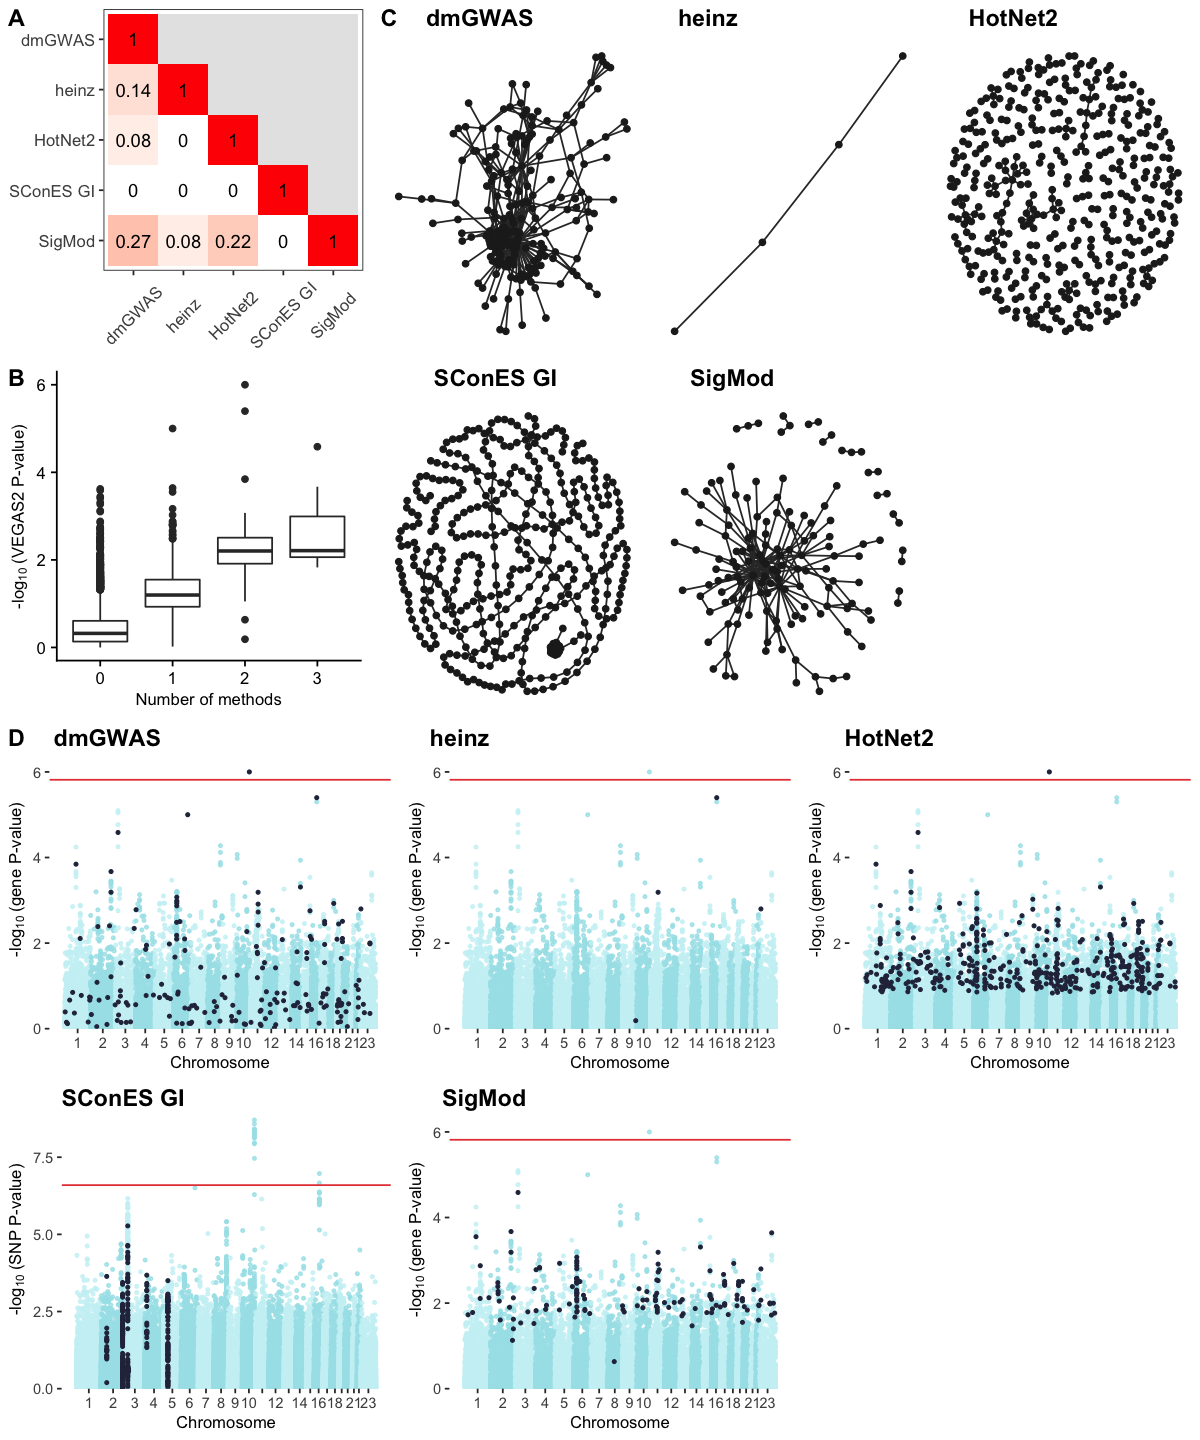

In [7]:
options(repr.plot.width=10, repr.plot.height=12)
f1
ggsave('figures/figure_1.pdf', f1, width=10, height=12, bg = "transparent")
ggsave('figures/figure_1.png', f1, width=10, height=12, bg = "transparent")

# Figure 2

In [8]:
##########################
#     MANHATTAN PANEL    # 
##########################
gwas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                        col_types = 'iciddddddcd') %>%
    mutate(selected = ifelse(`Top-0.1-pvalue` < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='Chr') %>%

  # Add a cumulative position of each gene
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$`Top-0.1-pvalue`), na.rm = TRUE) + 1
axisdf <- don %>% 
    group_by(Chr) %>% 
    summarize(center=( max(BPcum) + min(BPcum) ) / 2 ) %>%
    mutate(chr_fix = ifelse(Chr %in% c(14,16,18,20,21,23), '', Chr))

gene_manhattan <- ggplot(don, aes(x=BPcum, y=-log10(`Top-0.1-pvalue`))) +

    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha = .8, size = 1.2) +
    scale_color_manual(values = rep(c("#cbf1f5", "#a6e3e9"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = '#e84545') +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr_fix, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 22),
      axis.text = element_text(size = 15),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(gene P-value)')) +
    theme_transparent

consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidllllllli')$gene
consensus_mh <- gene_manhattan + geom_point(data = filter(don, Gene %in% consensus), 
                                            aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), 
                                            color = '#2b2e4a', size = 1.2)

##########################
#     TOPOLOGY PANEL     # 
##########################
cols_methods <- c('dmGWAS','heinz','HotNet2','SConES GI','SigMod')

vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)

ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    left_join(vegas, by = c('name' = 'Gene'))

set.seed(0)
consensus_nodes <- read_tsv(paste0(results,'consensus/consensus.tsv'), 
                            col_types = 'cdidllllllli')

consensus <- inner_join(ppi, consensus_nodes, by = c('name' = 'gene', 'p')) %>%
    mutate(betweenness = centrality_betweenness(normalized = TRUE),
           degree = centrality_degree())
class(consensus) <- 'igraph'

consensus <- consensus %>%
    ggnetwork %>%
    mutate(name = as.character(name))

nodes <- mutate(consensus, dmGWAS = as.numeric(dmgwas),
                heinz = as.numeric(heinz),
                HotNet2 = as.numeric(hotnet2),
                `SConES GI` = as.numeric(scones_gi),
                SigMod = as.numeric(sigmod),
                radius = ifelse(bcac | disgenet | degree > 6, .03, .02)) %>%
    filter(xend == x & yend == y) %>% 
    select(x, y, name, radius, p, betweenness, bcac, disgenet, cols_methods) %>%
    unique
edges <- filter(consensus, xend != x | yend != y)

consensus_pies <- ggplot() +
    geom_edges(data = edges, aes(x = x, y = y, xend = xend, yend = yend), 
               color = '#393e46', size = 2) +
    geom_scatterpie(data = nodes, aes(x = x, y = y, r = radius), cols = cols_methods) +
#     geom_label_repel(data = filter(nodes, degree > 6 | bcac | disgenet), 
#                      aes(x = x, y = y, label = name, color = (bcac | disgenet)), 
#                      nudge_x = -.05, nudge_y = -.05, alpha = .8, label.size = NA,
#                      hjust = 0.5, vjust = 0.5, size = 6) + 
    coord_fixed() +
    theme_blank() +
    labs(fill = 'Method') +
    scale_color_manual(values = c('TRUE' = '#e96182', 'FALSE' = 'black')) +
    scale_fill_manual(values = method_palette) +
    guides(color = FALSE) +
    theme(legend.position = 'left',
          legend.text = element_text(size = 20, vjust = .2),
          legend.title = element_text(size = 22, vjust = 1)) +
    theme_transparent

##########################
#       NAMED PANEL      # 
##########################
consensus_names <- ggplot() +
    geom_edges(data = edges, aes(x = x, y = y, xend = xend, yend = yend), 
               color = '#393e46', size = 4) +
    geom_point(data = nodes, aes(x = x, y = y, color = (bcac | disgenet)), size = 10) + 
    geom_label_repel(data = nodes, aes(x = x, y = y, label = name, color = (bcac | disgenet)), size = 10) + 
    coord_fixed() +
    theme_blank() +
    labs(fill = 'Method') +
    scale_color_manual(values = c('TRUE' = '#e96182', 'FALSE' = 'black')) +
    scale_fill_manual(values = method_palette) +
    guides(color = FALSE) +
    theme_transparent

f2 <- plot_grid(plot_grid(consensus_mh, consensus_pies, ncol = 2, 
                           labels = c('A','B'), label_size = 35),
                 consensus_names, 
                 labels = c('','C'), label_size = 35, rel_heights = c(1,3), nrow = 2)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(cols_methods)` instead of `cols_methods` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



Warning message:
“ggrepel: 77 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


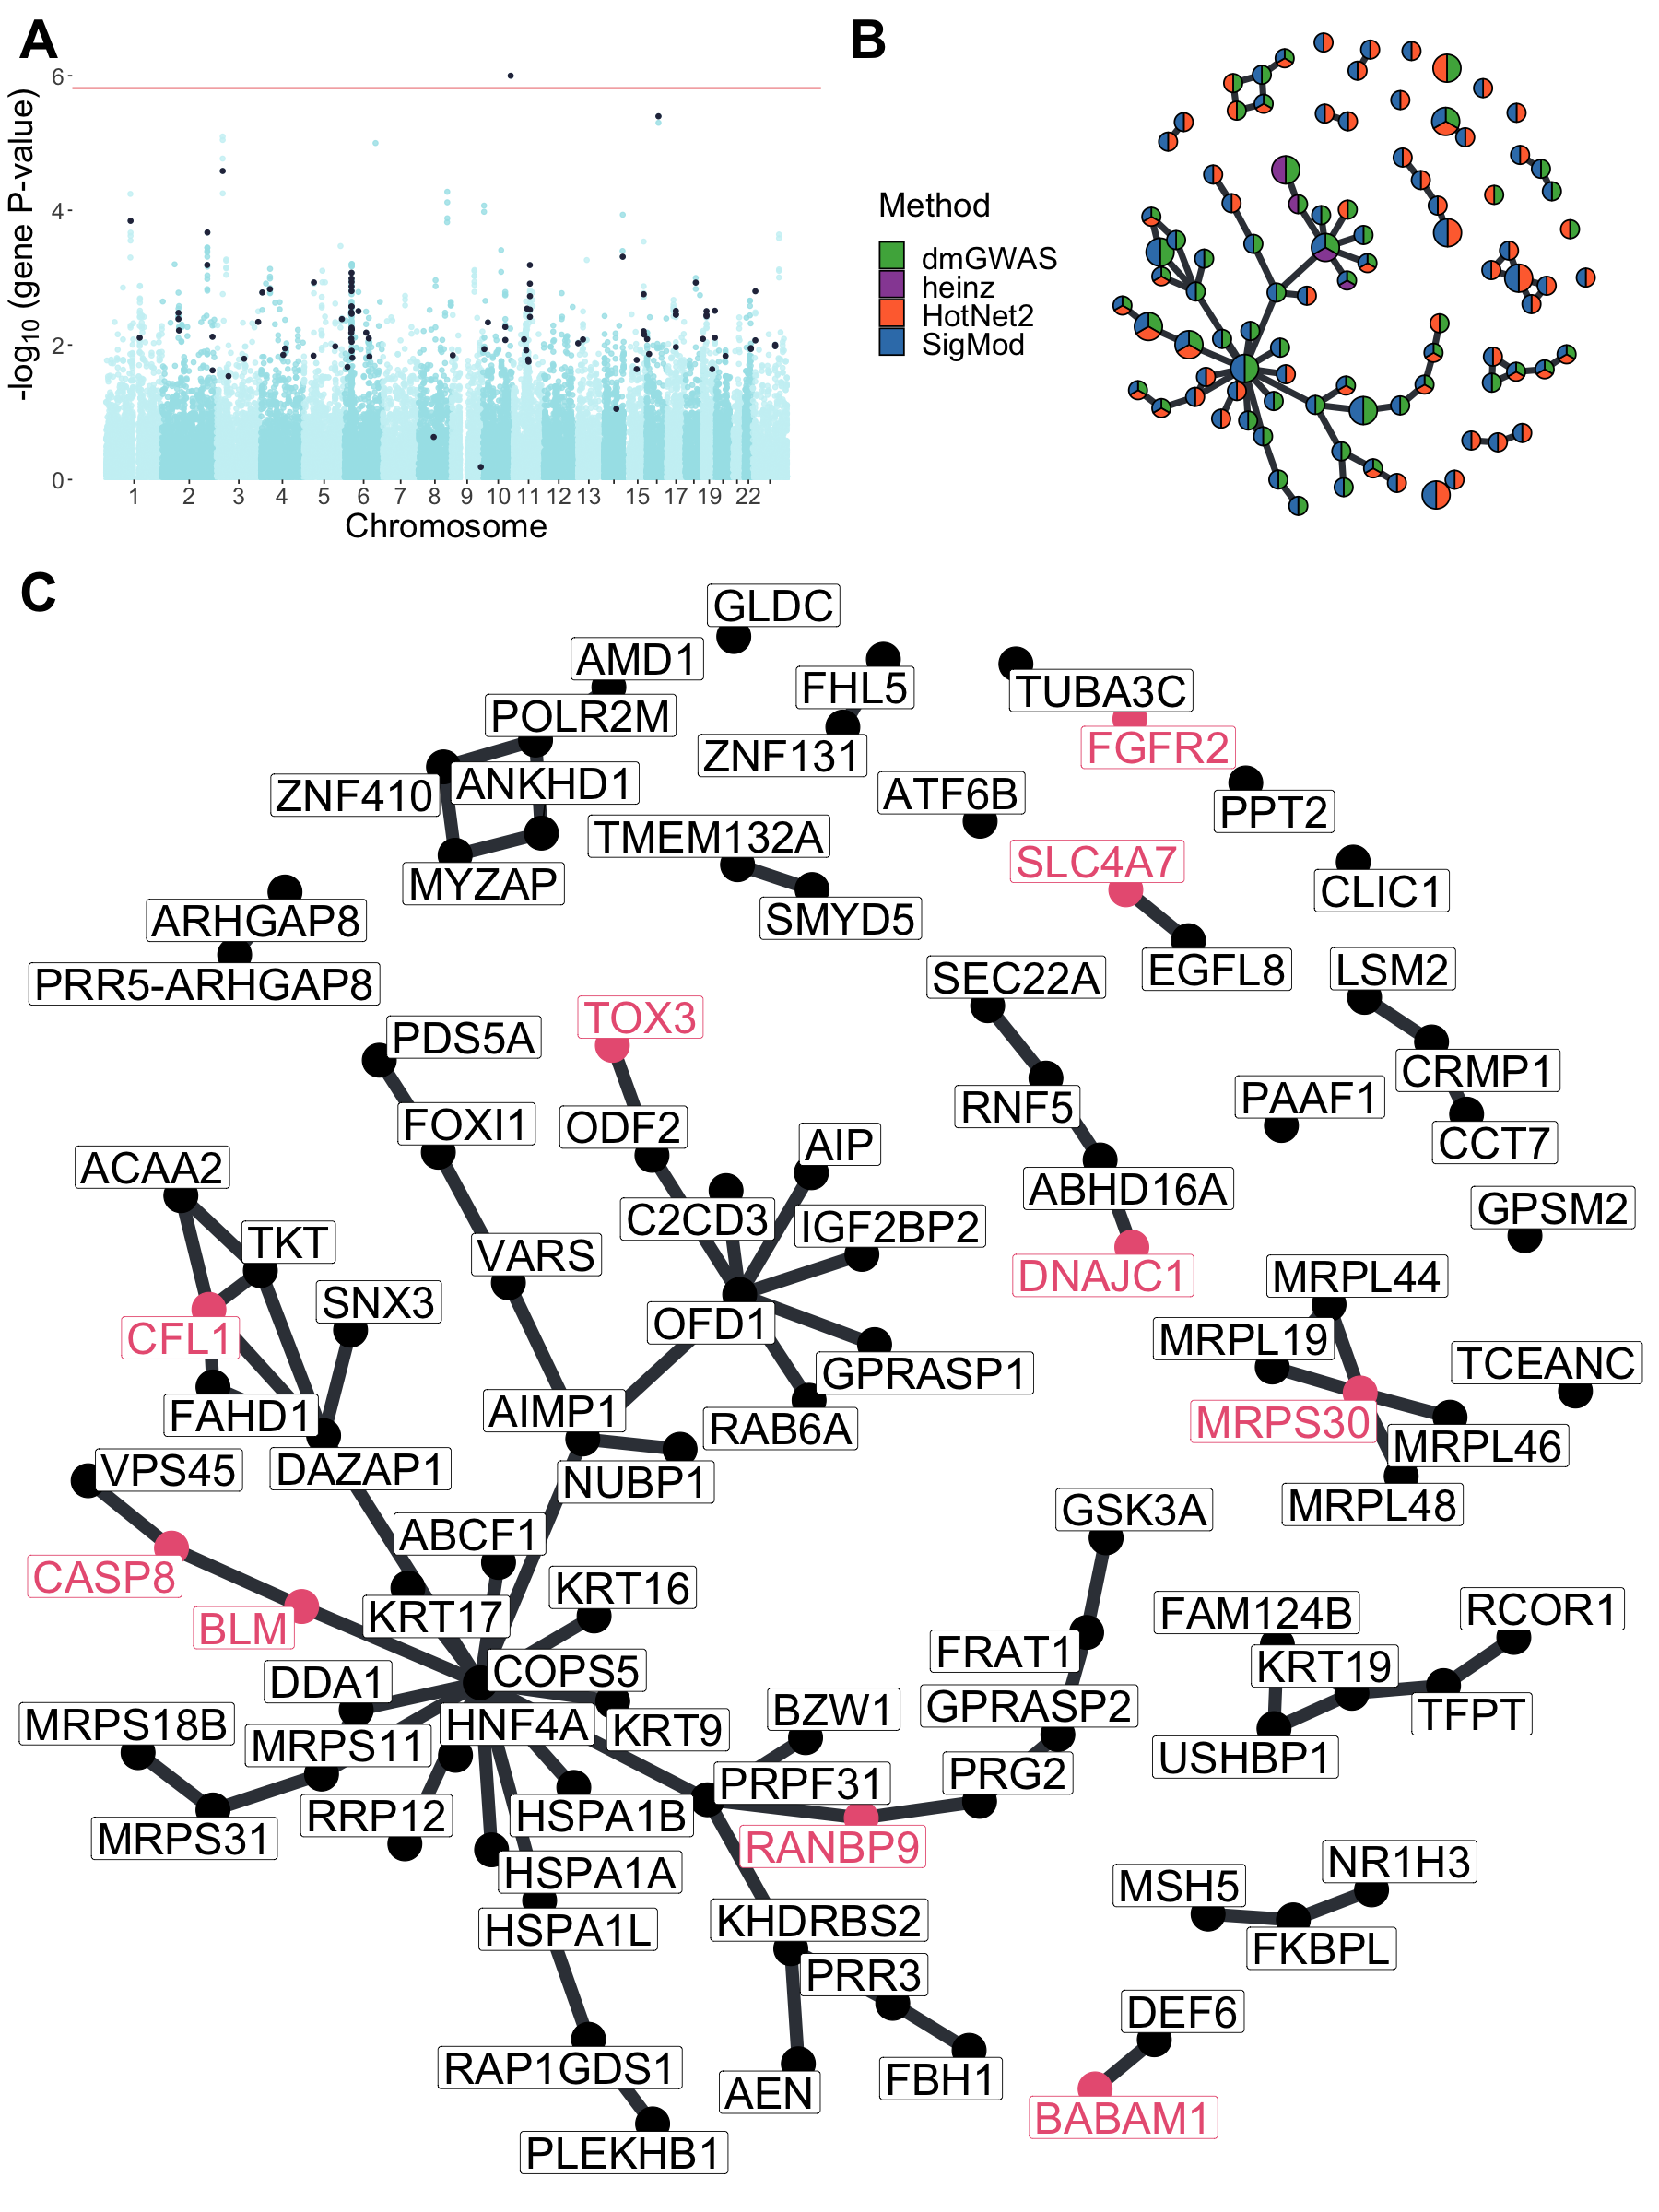

In [9]:
options(repr.plot.width=15, repr.plot.height=20)
f2
ggsave('figures/figure_2.pdf', f2, width=15, height=20, bg = "transparent")

# Figure 3: Benchmark

In [10]:
methods <- c('dmGWAS','heinz','HotNet2','LEAN','SigMod','All',
             'SConES~GS','SConES~GM','SConES~GI','Consensus',
             'chi^2~+~Bonferroni')
labs <- c('all_snps' = 'All', 'chi^2~+~Bonferroni' = bquote(chi^2 ~ '+ Bonferroni'), 
          'consensus' = 'Consensus', 'dmgwas' = 'dmGWAS', 'heinz' = 'heinz', 
          'hotnet2' = 'HotNet2', 'lean' = 'LEAN', 'SConES~GI' = 'SConES GI', 
          'SConES~GM' = 'SConES GM', 'SConES~GS' = 'SConES GS', 'sigmod' = 'SigMod',
          'VEGAS2' = 'VEGAS2', 'Consensus' = 'Consensus')

parse_deltatime <- function(column) {
    
    parse_subfield <- function (x) {
        if (grepl('ms', x)) {
            x <- gsub('ms', '', x) %>% as.numeric
            x <- x / 1000
        } else if (grepl('s', x)) {
            x <- gsub('s', '', x) %>% as.numeric
        } else if (grepl('m', x)) {
            x <- gsub('m', '', x) %>% as.numeric
            x <- x * 60
        } else if (grepl('h', x)) {
            x <- gsub('h', '', x) %>% as.numeric
            x <- x * 3600
        } else if (grepl('d', x)) {
            x <- gsub('d', '', x) %>% as.numeric
            x <- x * 3600 * 24
        } else {
            x <- NA
        }
        return(x)   
    }
    
    strsplit(column, ' ') %>% lapply(function(x) lapply(x, parse_subfield) %>% unlist) %>% lapply(sum) %>% unlist  
}
                                     
scientific_10 <- function(x) {
    parse(text=gsub("1e", "10^", scales::scientific_format()(x)) %>% gsub("\\+", "", .))
}

pred_ht <- read_tsv(paste0(results,'benchmark/prediction.tsv'), col_types = 'ciidd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones_gs', 'SConES~GS', method),
           method = ifelse(method == 'scones_gm', 'SConES~GM', method),
           method = ifelse(method == 'scones_gi', 'SConES~GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'all_snps', 'All', method),
           method = ifelse(method == 'consensus', 'Consensus', method),
           method = ifelse(method == 'chi2', 'chi^2~+~Bonferroni', method),
           method = factor(method, levels = rev(methods)))

stab_ht <- read_tsv(paste0(results,'benchmark/stability.tsv'), col_types = 'cicd') %>%
    filter(! method %in% c('lean','all_snps')) %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones_gs', 'SConES~GS', method),
           method = ifelse(method == 'scones_gm', 'SConES~GM', method),
           method = ifelse(method == 'scones_gi', 'SConES~GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'consensus', 'Consensus', method),
           method = ifelse(method == 'chi2', 'chi^2~+~Bonferroni', method),
           method = factor(method, levels = rev(methods)))

In [11]:
read_vegas <- function() {
    chi2 <- read_tsv(paste0(results, 'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd') %>%
        filter(Gene %in% bcac$Gene)
    thresholds <- c(1e-6, 1e-4, 1e-2, seq(0, 1, 0.05))
    
    lapply(thresholds, function(cutoff) {
        filter(chi2, `Top-0.1-pvalue` < cutoff) %>%
            add_row(Gene = NA) %>%
            mutate(method = 'VEGAS2',
                   tp = Gene %in% P_genes,
                   params = as.character(cutoff)) %>%
        select(Gene, method, params, tp)
    }) %>%
    bind_rows
}

read_dmgwas <- function() {
    
    lapply(list.files(paste0(results,'params/dmgwas'), full.names = T, pattern = 'dmgwas_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            add_row(gene = NA) %>%
            mutate(params = gsub('.*dmgwas_', '', f)  %>% gsub('.txt', '', .),
                   d = gsub('d_', '', params) %>% gsub('_r_.*', '', .) %>% as.numeric,
                   r = gsub('d_[1-3]_r_', '', params) %>% as.numeric, 
                   method = 'dmGWAS',
                   tp = gene %in% P_genes)
        }) %>%
        bind_rows
    
}

read_heinz <- function() {
    lapply(list.files(paste0(results,'params/heinz'), full.names = T, pattern = 'heinz_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            add_row(gene = NA) %>%
            mutate(params = gsub('.*heinz_', '', f)  %>% gsub('.txt', '', .),
                   method = 'heinz',
                   tp = gene %in% P_genes)
        }) %>%
        bind_rows
}

read_hotnet <- function() {
    lapply(list.files(paste0(results,'params/hotnet2'), full.names = T, pattern = 'hotnet2_*'), function(f) {
        read_tsv(f, col_types = 'ci') %>%
            select(gene) %>%
            add_row(gene = NA) %>%
            mutate(params = gsub('.*hotnet2_', '', f)  %>% gsub('.tsv', '', .),
                   method = 'HotNet2',
                   tp = gene %in% P_genes)
        }) %>%
        bind_rows
}

read_lean <- function() {
    lean <- read_tsv(paste0(results, 'lean/scored_genes.lean.txt'), col_types = 'cddiidddd')

    lapply(seq(0, 1, 0.025), function(cutoff) {
        filter(lean, PLEAN < cutoff) %>%
            add_row(Gene = NA) %>%
            mutate(method = 'LEAN',
                   tp = Gene %in% P_genes,
                   params = as.character(cutoff)) %>%
        select(Gene, method, params, tp)
    }) %>%
        bind_rows
}

read_sigmod <- function() {
    
    lapply(list.files(paste0(results,'params/sigmod'), full.names = T, pattern = 'sigmod_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            mutate(params = gsub('.*sigmod_', '', f)  %>% gsub('.txt', '', .),
                   lambdamax = gsub('lambdamax_', '', params) %>% gsub('_nmax_.*', '', .) %>% as.numeric,
                   nmax = gsub('lambdamax_1_nmax_', '', params) %>% gsub('_maxjump_.*', '', .)  %>% as.numeric, 
                   maxjump = gsub('lambdamax_1_nmax_[0-9]+_maxjump_', '', params) %>% as.numeric, 
                   method = 'SigMod',
                   tp = gene %in% P_genes)
        }) %>%
        bind_rows
    
}

read_scones <- function(run) {
    lapply(list.files(paste0(results,'params/scones/run_', run), full.names = T, pattern = 'cones_*'), function(f) {
        read_tsv(f, col_types = 'ciidccdli') %>%
            select(snp, selected) %>%
            mutate(params = gsub('.*cones_', '', f)  %>% gsub('.tsv', '', .),
                   eta    = gsub('eta_', '', params) %>% gsub('_lambda_.*', '', .) %>% as.numeric,
                   lambda = gsub('eta_.*_lambda_', '', params) %>% as.numeric,
                   method = 'SConES GI',
                   tp = ifelse(selected, snp %in% P_snps, FALSE))
        }) %>%
        bind_rows %>%
        group_by(method, params, eta, lambda) %>%
        summarize(tpr  = sum(tp) / length(P_snps),
                  fpr  = (sum(selected) - sum(tp)) / length(N_snps),
                  n    = sum(selected),
                  type = 'snp') %>%
        ungroup
}
           
read_chi2 <- function() {
    chi2 <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), col_types = 'icdccccddd')
    thresholds <- c(1e-6, 1e-4, 1e-2, seq(0, 1, 0.05))
    
    lapply(thresholds, function(cutoff) {
        filter(chi2, P < cutoff) %>%
            add_row(SNP = NA) %>%
            rename(snp = SNP) %>%
            mutate(method = 'chi^2~+~Bonferroni',
                   tp = snp %in% P_snps,
                   params = as.character(cutoff)) %>%
        select(snp, method, params, tp)
    }) %>%
    bind_rows %>%
    group_by(method, params) %>%
    summarize(tpr = sum(tp) / length(P_snps),
              fpr = (n() - sum(tp)) / length(N_snps),
              n   = n(),
              type = 'snp')
}

ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`)

bcac <- read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), col_types = 'iciddddddcd') %>%
    # remove genes not in the PPI
    filter(Gene %in% ppi$`Official Symbol Interactor A` | Gene %in% ppi$`Official Symbol Interactor B`)
bcac_snps <- read_tsv(paste0(results,'bcac/oncoarray_bcac_public_release_oct17.genesis.assoc'), col_types = 'icdcddcddd') %>%
    mutate(padj = p.adjust(P, method = 'bonferroni'))

## genes
P_genes <- filter(bcac, `Top-0.1-pvalue` < 0.05 / n())$Gene
N_genes <- filter(bcac, `Top-0.1-pvalue` >= 0.05 / n())$Gene

## snps
P_snps <- filter(bcac_snps, padj  < 0.05 / n())$SNP
N_snps <- filter(bcac_snps, padj >= 0.05 / n())$SNP

vegas_pars <- read_vegas()
dmgwas_pars <- read_dmgwas()
heinz_pars <- read_heinz()
hotnet_pars <- read_hotnet()
lean_pars <- read_lean()
sigmod_pars <- read_sigmod()
scones_pars <- read_scones(1)
scones_pars2 <- read_scones(2)
chi2_pars <- read_chi2()

stats <- bind_rows(vegas_pars,
                   dmgwas_pars %>% select(-d, -r),
                   heinz_pars,
                   hotnet_pars,
                   lean_pars,
                   sigmod_pars %>% select(-lambdamax, -nmax, -maxjump)
                  ) %>%
    group_by(method, params) %>%
    summarize(fpr = (n() - sum(tp)) / length(N_genes),
              tpr = sum(tp) / length(P_genes),
              n   = n(),
              type = 'gene') %>%
    bind_rows(scones_pars %>% select(-eta, -lambda),
              chi2_pars) %>%
    ungroup %>%
    add_row(method = 'VEGAS2', params = NA, tpr = 1, fpr = 1, type = 'gene') %>%
    add_row(method = 'dmGWAS', params = NA, tpr = 1, fpr = 1, type = 'gene') %>%
    add_row(method = 'heinz', params = NA, tpr = 1, fpr = 1, type = 'gene') %>%
    add_row(method = 'HotNet2', params = NA, tpr = 1, fpr = 1, type = 'gene') %>%
    add_row(method = 'LEAN', params = NA, tpr = 1, fpr = 1, type = 'gene') %>%
    add_row(method = 'SigMod', params = NA, tpr = 1, fpr = 1, type = 'gene') %>%
    add_row(method = 'chi^2~+~Bonferroni', params = NA, tpr = 1, fpr = 1, type = 'snp') %>%
    add_row(method = 'SConES GI', params = NA, tpr = 1, fpr = 1, type = 'snp')

`summarise()` regrouping output by 'method', 'params', 'eta' (override with `.groups` argument)

`summarise()` regrouping output by 'method', 'params', 'eta' (override with `.groups` argument)

`summarise()` regrouping output by 'method' (override with `.groups` argument)

`summarise()` regrouping output by 'method' (override with `.groups` argument)



In [12]:
sel_act <- pred_ht %>%
    filter(! method %in% c('All', 'SConES~GS', 'SConES~GM')) %>%
    group_by(method) %>%
    summarize(se_selected = sd(n_selected) / sqrt(n()),
              se_active = sd(n_active_set) / sqrt(n()),
              n_selected = mean(n_selected),
              n_active_set = mean(n_active_set)) %>%
    ungroup %>%
    ggplot(aes(x = n_selected, y = n_active_set, 
               label = method, color = method)) +
        geom_abline(slope = 1, color = 'gray50', linetype="dashed") +
        geom_errorbar(aes(ymin = n_active_set - se_active, 
                          ymax = n_active_set + se_active), width = 400) +
        geom_errorbarh(aes(xmin = n_selected - se_selected, 
                           xmax = n_selected + se_selected), height = 40) +
        geom_point() +
        scale_fill_manual(values = method_palette) +
        scale_color_manual(values = method_palette) +
        labs(x = 'Number of selected SNPs', y = 'Active set size', 
             color = 'Method') +
        theme(legend.position = 'none',
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              axis.title.y = element_text(size = 11)) + 
        guides(fill = "none")

naive_classifier <- max(table(fam$X6) / nrow(fam))

auc <- stats %>%
    add_row(method = 'Consensus') %>%
    filter(! method %in% c('chi2', 'vegas')) %>%
    ggplot(aes(fpr, tpr, color = method)) +
        geom_point() +
        geom_line() +
        geom_abline(slope = 1) +
        labs(x = 'False positive rate', y = 'True positive rate', color = 'Method') +
        scale_x_continuous(lim = c(0, 1)) +
        scale_y_continuous(lim = c(0, 1)) +
        scale_color_manual(values = method_palette, labels = labs) +
        theme(legend.position = 'bottom',
              text = element_text(size = 9),
              axis.title = element_text(size = 11))

corr <- filter(stab_ht, ! method %in% c('All', 'SConES~GS', 'SConES~GM')) %>%
    ggplot(aes(x = method, y = pearson, fill = method)) +
        geom_boxplot(color = 'gray20') +
        scale_x_discrete(labels = labs) +
        coord_flip() +
        labs(y = 'Pearson\'s correlation') +
        scale_fill_manual(values = method_palette) +
        theme(axis.title.y = element_blank(),
              legend.position = 'none',
              axis.text = element_text(size = 9),
              axis.title.x = element_text(size = 11))

time <- read_tsv(paste0(results,'benchmark/trace.txt'), col_types = 'iciccicccccccc') %>%
    separate(name, into = c('method','i'), sep = ' \\(') %>%
    filter(! method %in% c('lasso','make_splits','stability','all_snps',
                           'do_nothing','join_stability','join_analyses')) %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones' & grepl('gs', i), 'SConES~GS', method),
           method = ifelse(method == 'scones' & grepl('gm', i), 'SConES~GM', method),
           method = ifelse(method == 'scones' & grepl('gi', i), 'SConES~GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           method = ifelse(method == 'chi2', 'chi^2~+~Bonferroni', method),
           method = ifelse(method == 'consensus', 'Consensus', method),
           alg_time_s = parse_deltatime(realtime),
           tot_time_s = alg_time_s + mean(alg_time_s[method == 'vegas']),
           tot_time_s = ifelse(method == 'SConES GI', alg_time_s, tot_time_s),
           type = ifelse(grepl('SConES', method), 'SNP', 'Gene')) %>%
    filter(! method %in% c('All', 'Consensus', 'chi^2~+~Bonferroni', 'SConES~GS', 'SConES~GM', 'vegas')) %>%
    mutate(method = factor(method, levels = rev(methods))) %>%
    select(method, alg_time_s, tot_time_s, type) %>%
    gather(time_type, time_s, -type, -method) %>%
    filter(!(method == 'SConES~GI' & time_type == 'tot_time_s')) %>%
    mutate(time_type = ifelse(time_type == 'alg_time_s', 'Algorithm', 'Total (Algorithm + VEGAS2)')) %>%
    ggplot(aes(x = method, y = time_s, fill = method, shape = time_type, size = time_type)) +
        geom_point(color = 'black') +
        scale_fill_manual(values = method_palette) +
        scale_color_manual(values = method_palette) +
        scale_x_discrete(label=labs) +
        scale_y_log10(label=scientific_10) +
        labs(y = 'Time (s)', shape = 'Time') +
        theme(legend.position = 'bottom',
              legend.text=element_text(size = 10),
              axis.title.y = element_blank(),
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              strip.text = element_text(size = 10),
              strip.background = element_rect(fill="gray90")) +
        scale_shape_manual(values=c('Algorithm' = 25, 'Total (Algorithm + VEGAS2)' = 21)) +
        scale_size_manual(values=c('Algorithm' = 1.5, 'Total (Algorithm + VEGAS2)' = 3)) +
        guides(fill = FALSE, color = FALSE, size = FALSE, shape = guide_legend(nrow=2, byrow=TRUE)) +
        coord_flip() +
        facet_grid(type ~ ., scales = 'free', space = 'free')

f3 <- plot_grid(
        plot_grid(sel_act, corr, ncol = 2, labels = c('A','B')),
        plot_grid(time, auc + theme(legend.position = 'none'), 
                  labels = c('C','D')),
        get_legend(auc),
        nrow = 3, rel_heights = c(1,1,.2))

`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“1 parsing failure.
row  col   expected actual                                file
 89 exit an integer      - '../../results/benchmark/trace.txt'
”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [128, 133].”
Warning message:
“Removed 4 rows containing missing values (geom_point).”
Warning message:
“Removed 4 row(s) containing missing values (geom_path).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”
Warning message:
“Removed 4 row(s) containing missing values (geom_path).”


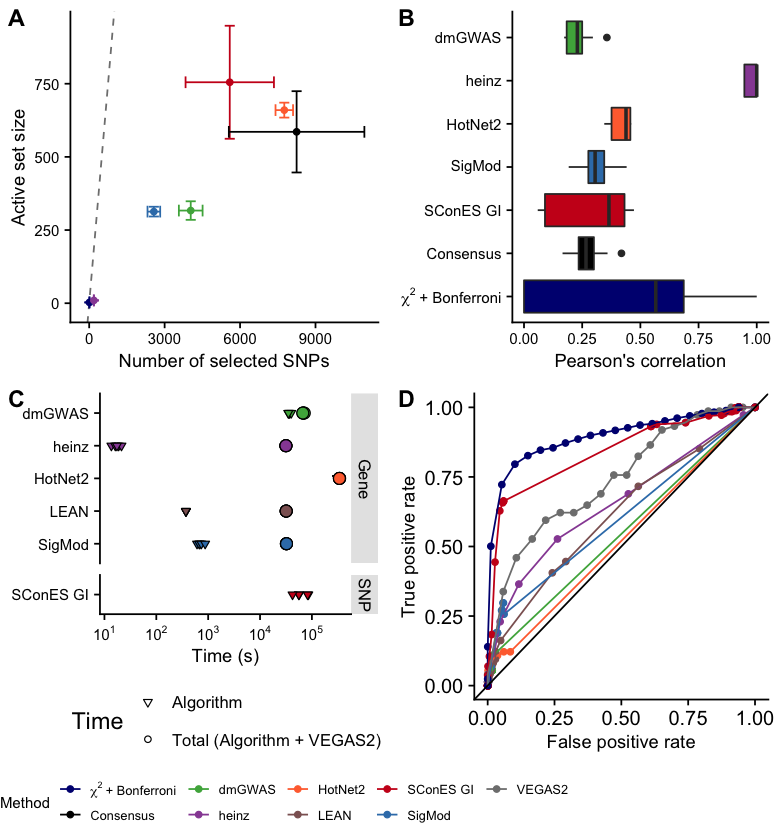

In [13]:
options(repr.plot.width=6.5, repr.plot.height=7)
f3
ggsave('figures/figure_3.pdf', f3, width=6.5, height=7, bg = "transparent")

# Figure 4

In [14]:
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidllllllli')$gene
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')$gene
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene

ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    left_join(vegas, by = c('name' = 'Gene'))
ppi_df <- as_tibble(ppi)

##########################
#         dmGWAS         # 
##########################
ppi_dmgwas <- activate(ppi, nodes) %>%
    filter(name %in% dmgwas)
class(ppi_dmgwas) <- 'igraph'

dmgwas_flaw <- ggnetwork(ppi_dmgwas) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray80') +
        geom_nodes(aes(fill = -log10(p)), shape = 21, size = 2.5, alpha = 0.5) +
        labs(fill = bquote('-log' [10] ~'(gene P-value)')) +
        theme_blank() +
        scale_fill_gradient(low = "white", high = "#dd2c00", na.value = NA) +
        theme(legend.position = 'bottom') +
        theme_transparent

##########################
#         SConES         # 
##########################

gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli")
gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli")
gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = "ciiiccdli")
snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')

scones_regions <- join_experiments(GS = gs, GM = gm, GI = gi) %>%
    gather(key = "experiment", value = "selected", starts_with("selected")) %>%
    filter(selected) %>%
    mutate(experiment = gsub("selected_", "", experiment)) %>%
    left_join(snp2gene, by = "snp") %>%
    group_by(snp) %>%
    summarize(experiment = list(unique(experiment)),
              in_gene = ifelse(any(!is.na(gene)), 'Yes', 'No')) %>%
    ggplot(aes(experiment, fill = in_gene)) +
        geom_bar(stat = 'count') +
        scale_x_upset() +
        labs(x = 'SConES network', y = 'Number of selected SNPs', fill = 'Overlaps with a gene') +
        scale_fill_manual(values=c("Yes" = "#17b978", 'No' = '#b8b0b0')) +
        theme_bw() +
        theme_transparent  +
        theme(legend.position = 'bottom',
              axis.text.x = element_text(size = 10),
              axis.title = element_text(size = 11),
              axis.ticks.y = element_blank(),
              panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(),
              legend.text = element_text(size = 10),
              legend.title = element_text(size = 11))

##########################
#     CENTRALITY vs P    # 
##########################
ppi_selection <- ppi %>%
    mutate(betweenness = centrality_betweenness(normalized = TRUE)) %>%
    inner_join(read_tsv(paste0(results,'bcac/scored_genes.vegas.join_genesis.txt'),
                        col_types = 'iciddddddcddddddcdll'), by = c('name' = 'Gene')) %>%
    mutate(p = Pvalue_bcac,
           what = ifelse(name %in% sigmod, 'SigMod', 'Unselected'),
           what = ifelse(name %in% dmgwas, 'dmGWAS', what),
           what = ifelse(name %in% hotnet2, 'HotNet2', what),
           what = ifelse(name %in% heinz, 'heinz', what),
           what = ifelse(name %in% consensus, 'Consensus', what))

centrality_p_plt <- ggplot() +
    geom_point(data = ppi_selection, aes(x = betweenness, y = -log10(p)), color = 'gray70', size = 2) +
    geom_point(data = filter(ppi_selection, what != 'Unselected'),
               aes(x = betweenness, y = -log10(p), fill = what), size = 2.5, shape = 21) +
    geom_label_repel(data = filter(ppi_selection, name %in% c('COPS5','FN1','CUL3','OFD1')) %>%
                                select(name, betweenness, p) %>%
                                as_tibble %>%
                                unique,
                     aes(x = betweenness, y = -log10(p), label = name), size = 4, alpha = 0.8) +
    guides(fill = guide_legend(ncol=2)) +
    labs(x = 'Betweenness', y = bquote('-log' [10] ~'(BCAC P-value)'), fill = 'Selected by') +
    theme(legend.position = 'bottom', 
          text = element_text(size = 11),
          axis.text = element_text(size = 10)) +
    scale_fill_manual(values = method_palette)

##########################
#  CENTRALITY vs REWIRE  # 
##########################
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    mutate(betweenness = centrality_betweenness(normalized = TRUE),
           degree = centrality_degree()) %>%
    left_join(vegas, by = c('name' = 'Gene'))
ppi_df <- as_tibble(ppi)

true_run <- bind_rows(read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c') %>%
                          mutate(method = 'heinz', run = 'Original', i = NA) %>%
                          inner_join(ppi_df, by = c('gene' = 'name')) %>%
                          select(method, run, i, gene, betweenness, p),
                      read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c') %>%
                          mutate(method = 'dmGWAS', run = 'Original', i = NA) %>%
                          inner_join(ppi_df, by = c('gene' = 'name')) %>%
                          select(method, run, i, gene, betweenness, p),
                      read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
                          filter(PLEAN < 0.05) %>%
                          rename(gene = Gene) %>%
                          mutate(method = 'LEAN', run = 'Original', i = NA) %>%
                          inner_join(ppi_df, by = c('gene' = 'name')) %>%
                          select(method, run, i, gene, betweenness, p),
                      read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c') %>%
                          mutate(method = 'SigMod', run = 'Original', i = NA) %>%
                          inner_join(ppi_df, by = c('gene' = 'name')) %>%
                          select(method, run, i, gene, betweenness, p)) %>%
             select(method, run, i, gene, betweenness, p)

read_heinz <- function() {
    lapply(list.files(paste0(results,'rewiring/heinz'), full.names = T, pattern = 'heinz_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            mutate(i = gsub('.*heinz_', '', f)  %>% gsub('.txt', '', .),
                   method = 'heinz')
        }) %>%
        bind_rows
}

read_dmgwas <- function() {
    
    lapply(list.files(paste0(results,'rewiring/dmgwas'), full.names = T, pattern = 'dmgwas_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            mutate(i = gsub('.*dmgwas_', '', f)  %>% gsub('.txt', '', .),
                   method = 'dmGWAS')
        }) %>%
        bind_rows
    
}

read_lean <- function() {
    
    lapply(list.files(paste0(results,'rewiring/lean'), full.names = T, pattern = 'lean_*'), function(f) {
        read_tsv(f, col_types = 'cddiidddd') %>%
            filter(PLEAN < 0.05) %>%
            rename(gene = Gene) %>%
            select(gene) %>%
            mutate(i = gsub('.*lean_', '', f)  %>% gsub('.txt', '', .),
                   method = 'LEAN')
    }) %>%
        bind_rows

}

read_sigmod <- function() {
    
    lapply(list.files(paste0(results,'rewiring/sigmod'), full.names = T, pattern = 'sigmod_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            mutate(i = gsub('.*sigmod_', '', f)  %>% gsub('.txt', '', .),
                   method = 'SigMod')
        }) %>%
        bind_rows
    
}

consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), 
                      col_types = 'cdidllllllli')$gene

runs <- bind_rows(read_dmgwas(),
                  read_heinz(),
                  read_lean(),
                  read_sigmod()) %>%
    mutate(run = 'Rewired') %>%
    inner_join(ppi_df, by = c('gene' = 'name'))  %>%
    select(method, run, i, gene, betweenness, degree, p) %>%
    bind_rows(true_run)

gene_agg <- runs %>%
    filter(run == 'Rewired' & method != 'SConES GI') %>%
    group_by(gene) %>%
    summarize(n = n(), betweenness = median(betweenness), degree = median(degree))

set.seed(0) # to fix overlapping tags
centrality_rewire_plt <- ggplot() +
    geom_point(data = gene_agg, aes(x = n, y = betweenness)) +
    geom_label_repel(data = filter(gene_agg, n > 150 & degree > 100 & gene %in% consensus),
                     aes(x = n, y = betweenness, label = gene)) +
    scale_y_log10() +
    labs(x = 'Times selected in random rewirings', y = 'Betweenness') +
    theme(legend.position = 'bottom', 
          text = element_text(size = 11),
          axis.text = element_text(size = 10))

f4 <- plot_grid(dmgwas_flaw, centrality_rewire_plt,
                centrality_p_plt, scones_regions, 
                labels = c('A','B','C','D'),
                rel_heights = c(1, 1.15))

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
`summarise()` ungrouping output (override with `.groups` argument)

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“Transformation introduced infinite values in continuous y-axis”


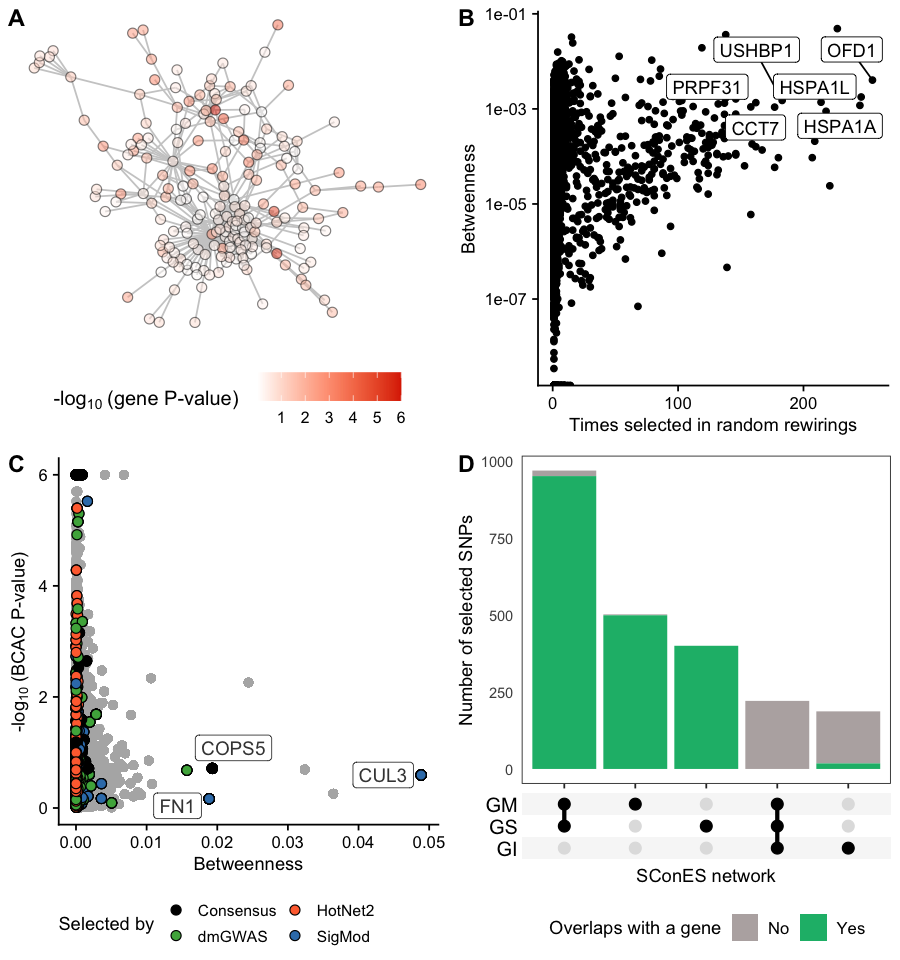

In [15]:
options(repr.plot.width=7.5, repr.plot.height=8)
f4
ggsave('figures/figure_4.pdf', f4, width=7.5, height=8,  bg = "transparent")

# Figure 5: stability consensus

In [16]:
##########################
#     MANHATTAN PANEL    # 
##########################
gwas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                        col_types = 'iciddddddcd') %>%
    mutate(selected = ifelse(`Top-0.1-pvalue` < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='Chr') %>%

  # Add a cumulative position of each gene
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$`Top-0.1-pvalue`), na.rm = TRUE) + 1
axisdf <- don %>% 
    group_by(Chr) %>% 
    summarize(center=( max(BPcum) + min(BPcum) ) / 2 ) %>%
    mutate(chr_fix = ifelse(Chr %in% c(14,16,18,20,21,23), '', Chr))

gene_manhattan <- ggplot(don, aes(x=BPcum, y=-log10(`Top-0.1-pvalue`))) +

    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha = .8, size = 1.2) +
    scale_color_manual(values = rep(c("#cbf1f5", "#a6e3e9"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = '#e84545') +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr_fix, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.text = element_text(size = 15),
      axis.title = element_text(size = 22),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(gene P-value)')) +
    theme_transparent

genes <- list.files(paste0(results, 'benchmark/all_outputs')) %>%
    lapply(function(x) {
        read_tsv(paste0(results, 'benchmark/all_outputs/', x), col_names = F, col_types = 'c') %>%
            rename(gene = X1) %>%
            filter(gene != 'gene') %>%
            unique %>%
            mutate(method = gsub('_[0-9]*.txt', '', x = x),
                   id = gsub('.*_', '', x = x),
                   id = gsub('.txt', '', x = id))
    }) %>%
    bind_rows %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'consensus', 'Consensus', method))

stab_consensus <- genes %>%
    filter(method != 'Consensus') %>%
    group_by(gene) %>%
    summarize(n = n()) %>%
    filter(n > 6) %>%
    arrange(-n) %>%
    .$gene
consensus_mh <- gene_manhattan + geom_point(data = filter(don, Gene %in% stab_consensus), 
                                            aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), 
                                            color = '#2b2e4a', size = 1.2)

##########################
#     TOPOLOGY PANEL     # 
##########################
cols_methods <- c('dmGWAS','heinz','HotNet2','SConES GI','SigMod')

vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    left_join(vegas, by = c('name' = 'Gene'))
class(ppi) <- c('igraph','tbl_graph')

genes_wide <- group_by(genes, gene, method) %>% 
    summarize(n = n()) %>% spread(key = method, value = n) %>%
    mutate(Consensus = ifelse(is.na(Consensus), 0, Consensus),
           dmGWAS = ifelse(is.na(dmGWAS), 0, dmGWAS),
           heinz = ifelse(is.na(heinz), 0, heinz),
           HotNet2 = ifelse(is.na(HotNet2), 0, HotNet2),
           `SConES GI` = ifelse(is.na(`SConES GI`), 0, `SConES GI`),
           SigMod = ifelse(is.na(SigMod), 0, SigMod),
           n = rowSums(cbind(dmGWAS, heinz, HotNet2, `SConES GI`, SigMod)))

# Read known genes
bcac_genes <- read_tsv(paste0(results,'bcac/scored_genes.vegas.join_genesis.txt'), 
                       col_types = 'iciddddddcddddddcdll') %>%
    filter(sign_bcac) %>%
    .$Gene

known_brca_genes <- read_tsv(paste0(results,'consensus/C0346153_disease_gda_summary.tsv'), 
                             col_types = 'ccciccciddddcddddd')$Gene

consensus_methods <- genes %>%
    filter(method != 'Consensus') %>%
    group_by(gene) %>%
    summarize(n = n()) %>%
    filter(n > 6) %>%
    arrange(-n) %>%
    .$gene

class(ppi) <- c('igraph','tbl_graph')

set.seed(0)
net <- ppi %>%
    filter(name %in% stab_consensus) %>%
    inner_join(genes_wide, by = c('name' = 'gene')) %>%
    mutate(known = name %in% bcac_genes | name %in% known_brca_genes,
           betweenness = centrality_betweenness(normalized = TRUE)) %>%
    ggnetwork

nodes <- filter(net, xend == x & yend == y)
edges <- filter(net, xend != x | yend != y)

consensus_pies <- ggplot(net, aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(size = 2, color = '#393e46') +
        geom_scatterpie(data = filter(net, x == xend & y == yend), 
                        aes(x = x, y = y, r = n/400), cols = cols_methods) +
#         geom_label_repel(data = filter(net, x == xend & y == yend & (known | degree > 4)), 
#                          aes(x = x, y = y, label = name, color = known), 
#                          nudge_x = -.05, nudge_y = -.05, alpha = .8, label.size = NA,
#                          hjust = 0.5, vjust = 0.5, size = 8) + 
        labs(fill = 'Method') +
        scale_color_manual(values = c('TRUE' = '#e96182', 'FALSE' = 'black')) +
        scale_fill_manual(values = method_palette) +
        guides(color = FALSE) +
        theme_blank() +
        theme(legend.position = 'left',
              legend.text = element_text(size = 20, vjust = .2),
              legend.title = element_text(size = 22, vjust = 1)) +
        theme_transparent

consensus_names <- ggplot() +
        geom_edges(data = edges, size = 4, color = '#393e46', 
                   aes(x = x, y = y, xend = xend, yend = yend, 
                       color = known), size = 4) +
        geom_point(data = nodes, aes(x = x, y = y, color = known), size = 10) +
        geom_label_repel(data = nodes, size = 10, 
                         aes(x = x, y = y, label = name, color = known)) + 
        coord_fixed() +
        theme_blank() +
        labs(fill = 'Method') +
        scale_color_manual(values = c('TRUE' = '#e96182', 'FALSE' = 'black')) +
        scale_fill_manual(values = method_palette) +
        guides(color = FALSE, size = FALSE) +
        theme_transparent

f5 <- plot_grid(plot_grid(consensus_mh, consensus_pies, ncol = 2, 
                          labels = c('A','B'), label_size = 35),
                 consensus_names, 
                 labels = c('','C'), label_size = 35, rel_heights = c(1,3), nrow = 2)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'gene' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“Duplicated aesthetics after name standardisation: size”


Warning message:
“ggrepel: 29 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


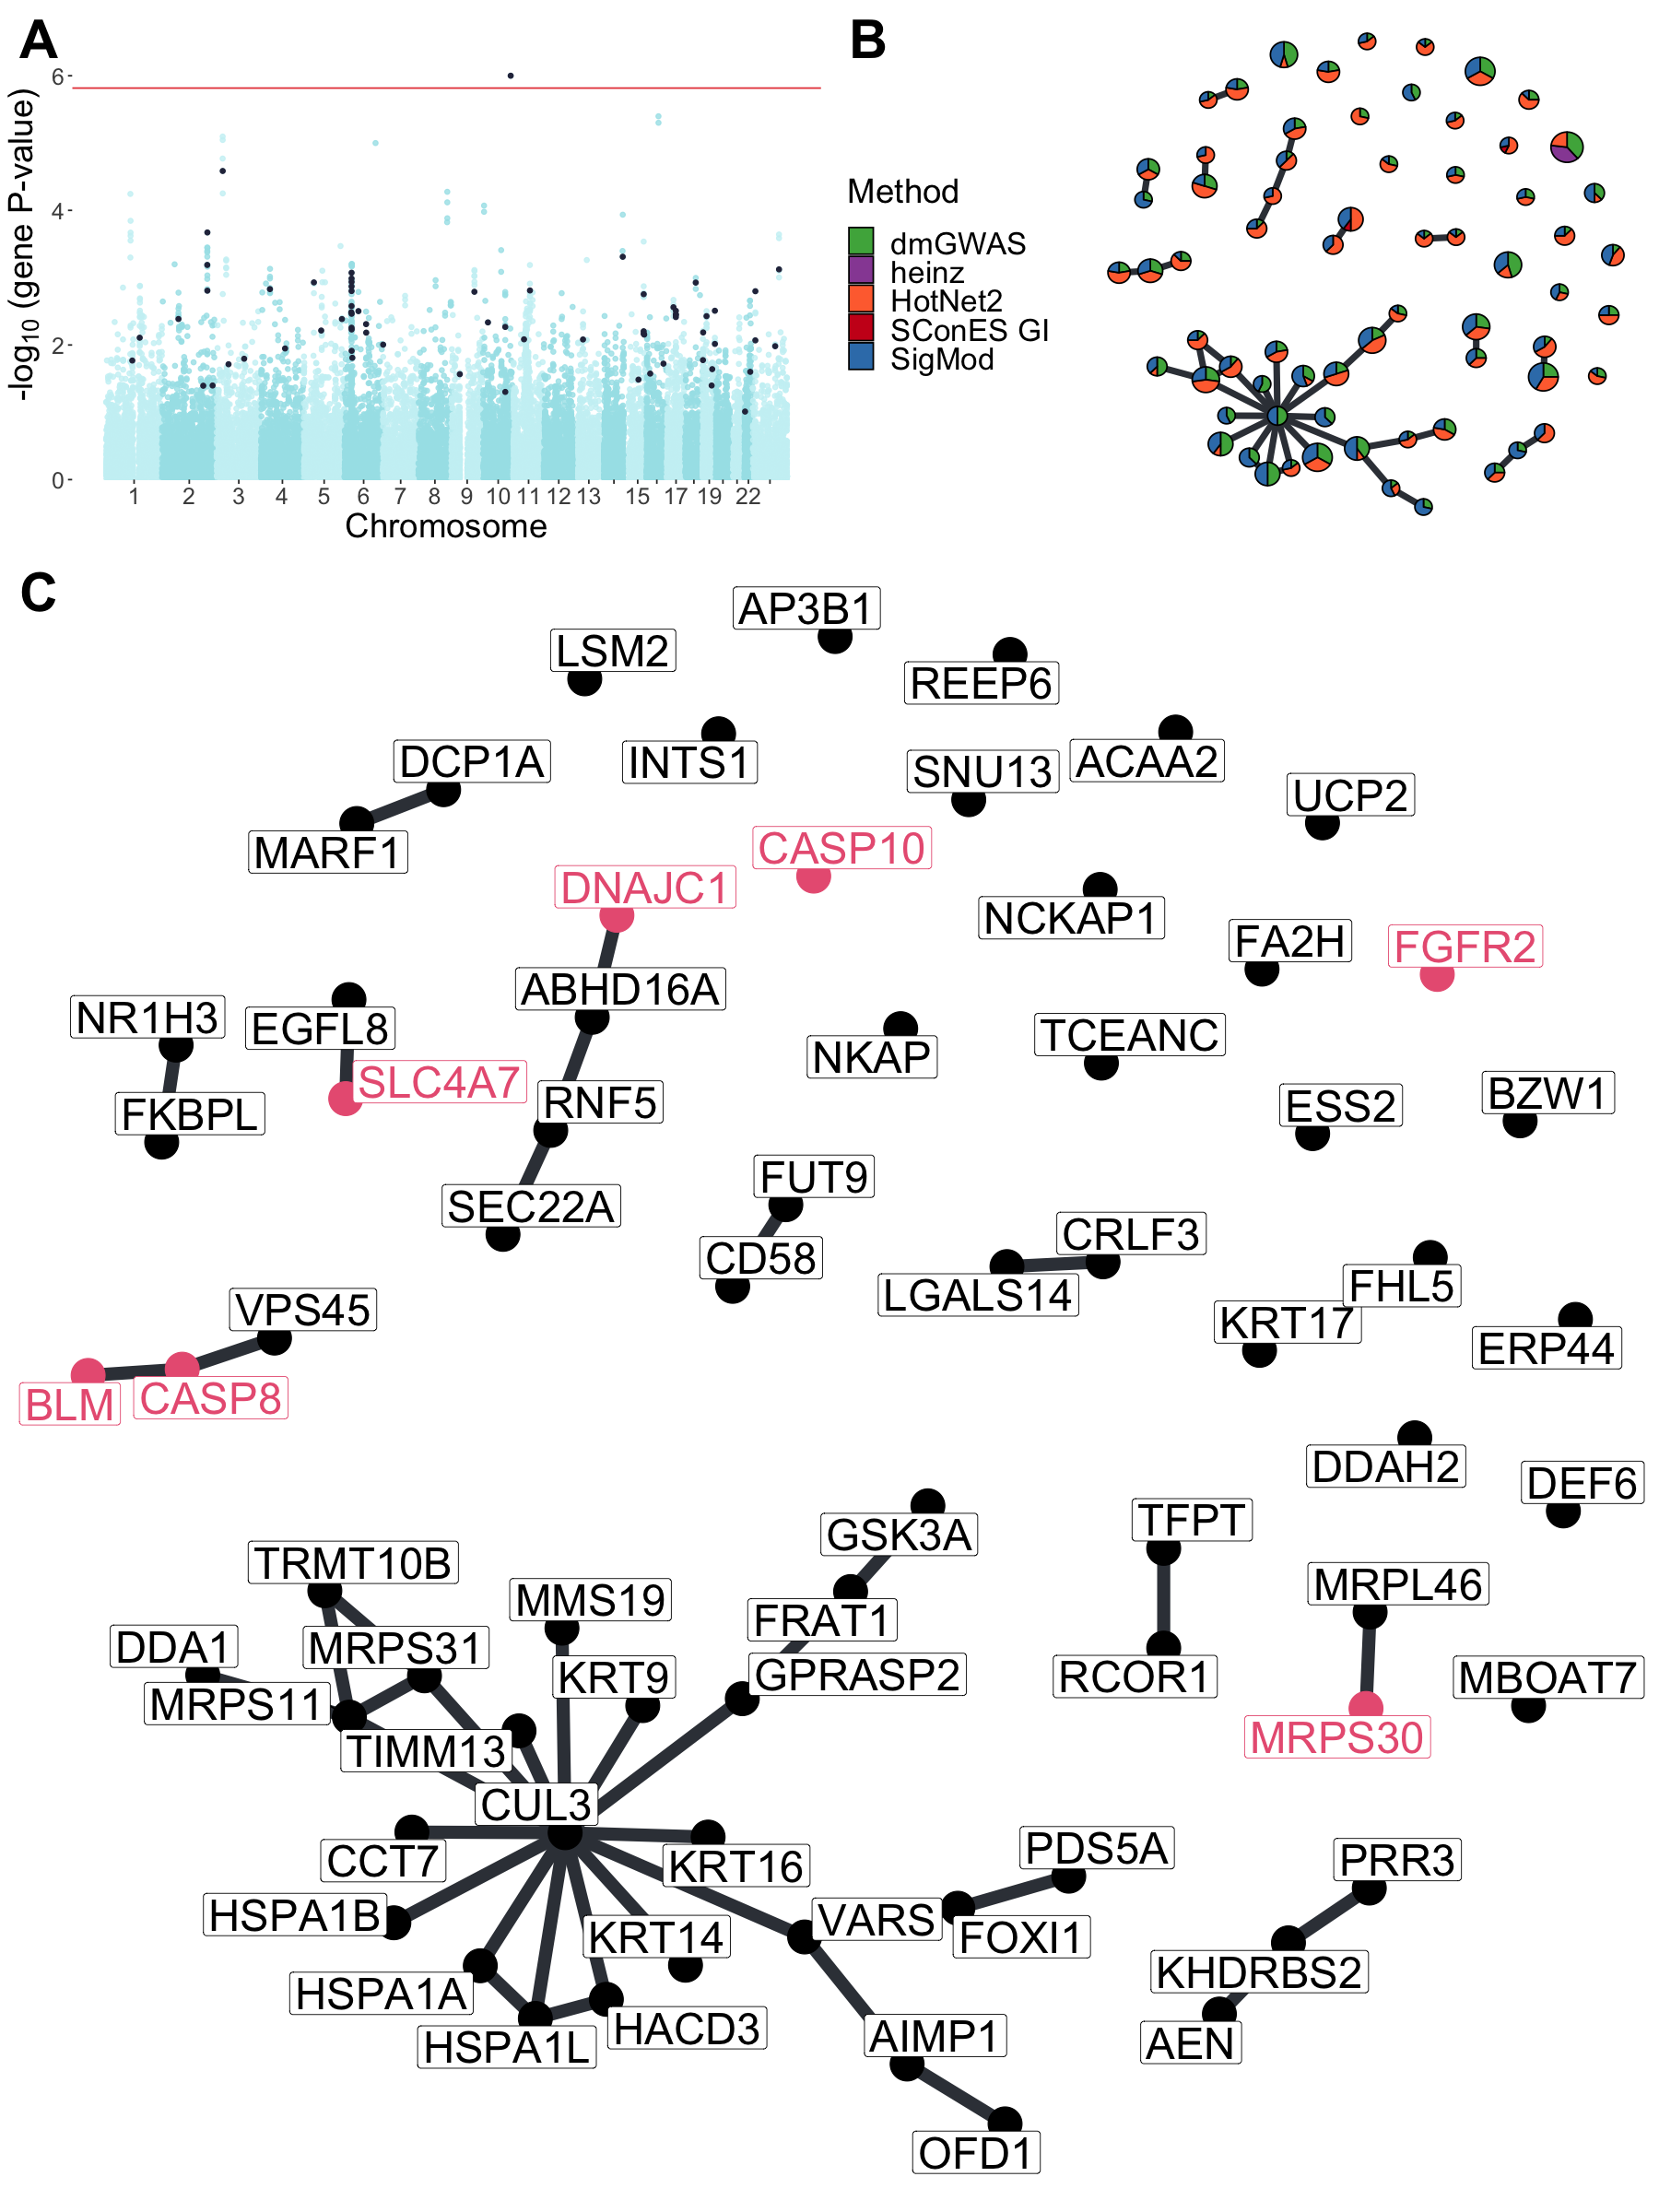

In [17]:
options(repr.plot.width=15, repr.plot.height=20)
f5
ggsave('figures/figure_5.pdf', f5, width=15, height=20, bg = "transparent")